In [1]:
from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

In [2]:
load_ext cython

In [3]:
import pickle

import numpy as np

from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.spatial import KDTree
from scipy.spatial import Delaunay

In [4]:
def cart2pol(coords):
    r = np.sqrt(coords[:,0]**2 + coords[:,1]**2)
    theta = np.arctan2(coords[:,1], coords[:,0])

    return np.stack((r,theta),1)

def pol2cart(coords):
    x = coords[:,0] * np.cos(coords[:,1])
    y = coords[:,0] * np.sin(coords[:,1])

    return np.stack((x,y), 1)

def fibonacci_sunflower(n_nodes):
    g_ratio = (np.sqrt(5) + 1) / 2
    nodes = np.arange(1,n_nodes+1)
    r = np.sqrt(nodes-0.5)/np.sqrt(n_nodes)
    r /= np.max(r)
    theta = 2 * np.pi * g_ratio * nodes

    return np.stack((r,theta), 1)

def fibonacci_retina(n_coords, fovea, foveal_density):
    coords = fibonacci_sunflower(n_coords)
    coords[:,0] /= (fovea + ((2*np.pi*fovea)/foveal_density)) ** coords[:,0] ** foveal_density
    coords[:,0] /= np.max(coords[:,0])

    return pol2cart(coords)

def visualize_locs(locs):
    plt.figure(figsize=(30,30))
    plt.plot(locs[:,0],locs[:,1],'k.')
    plt.show()

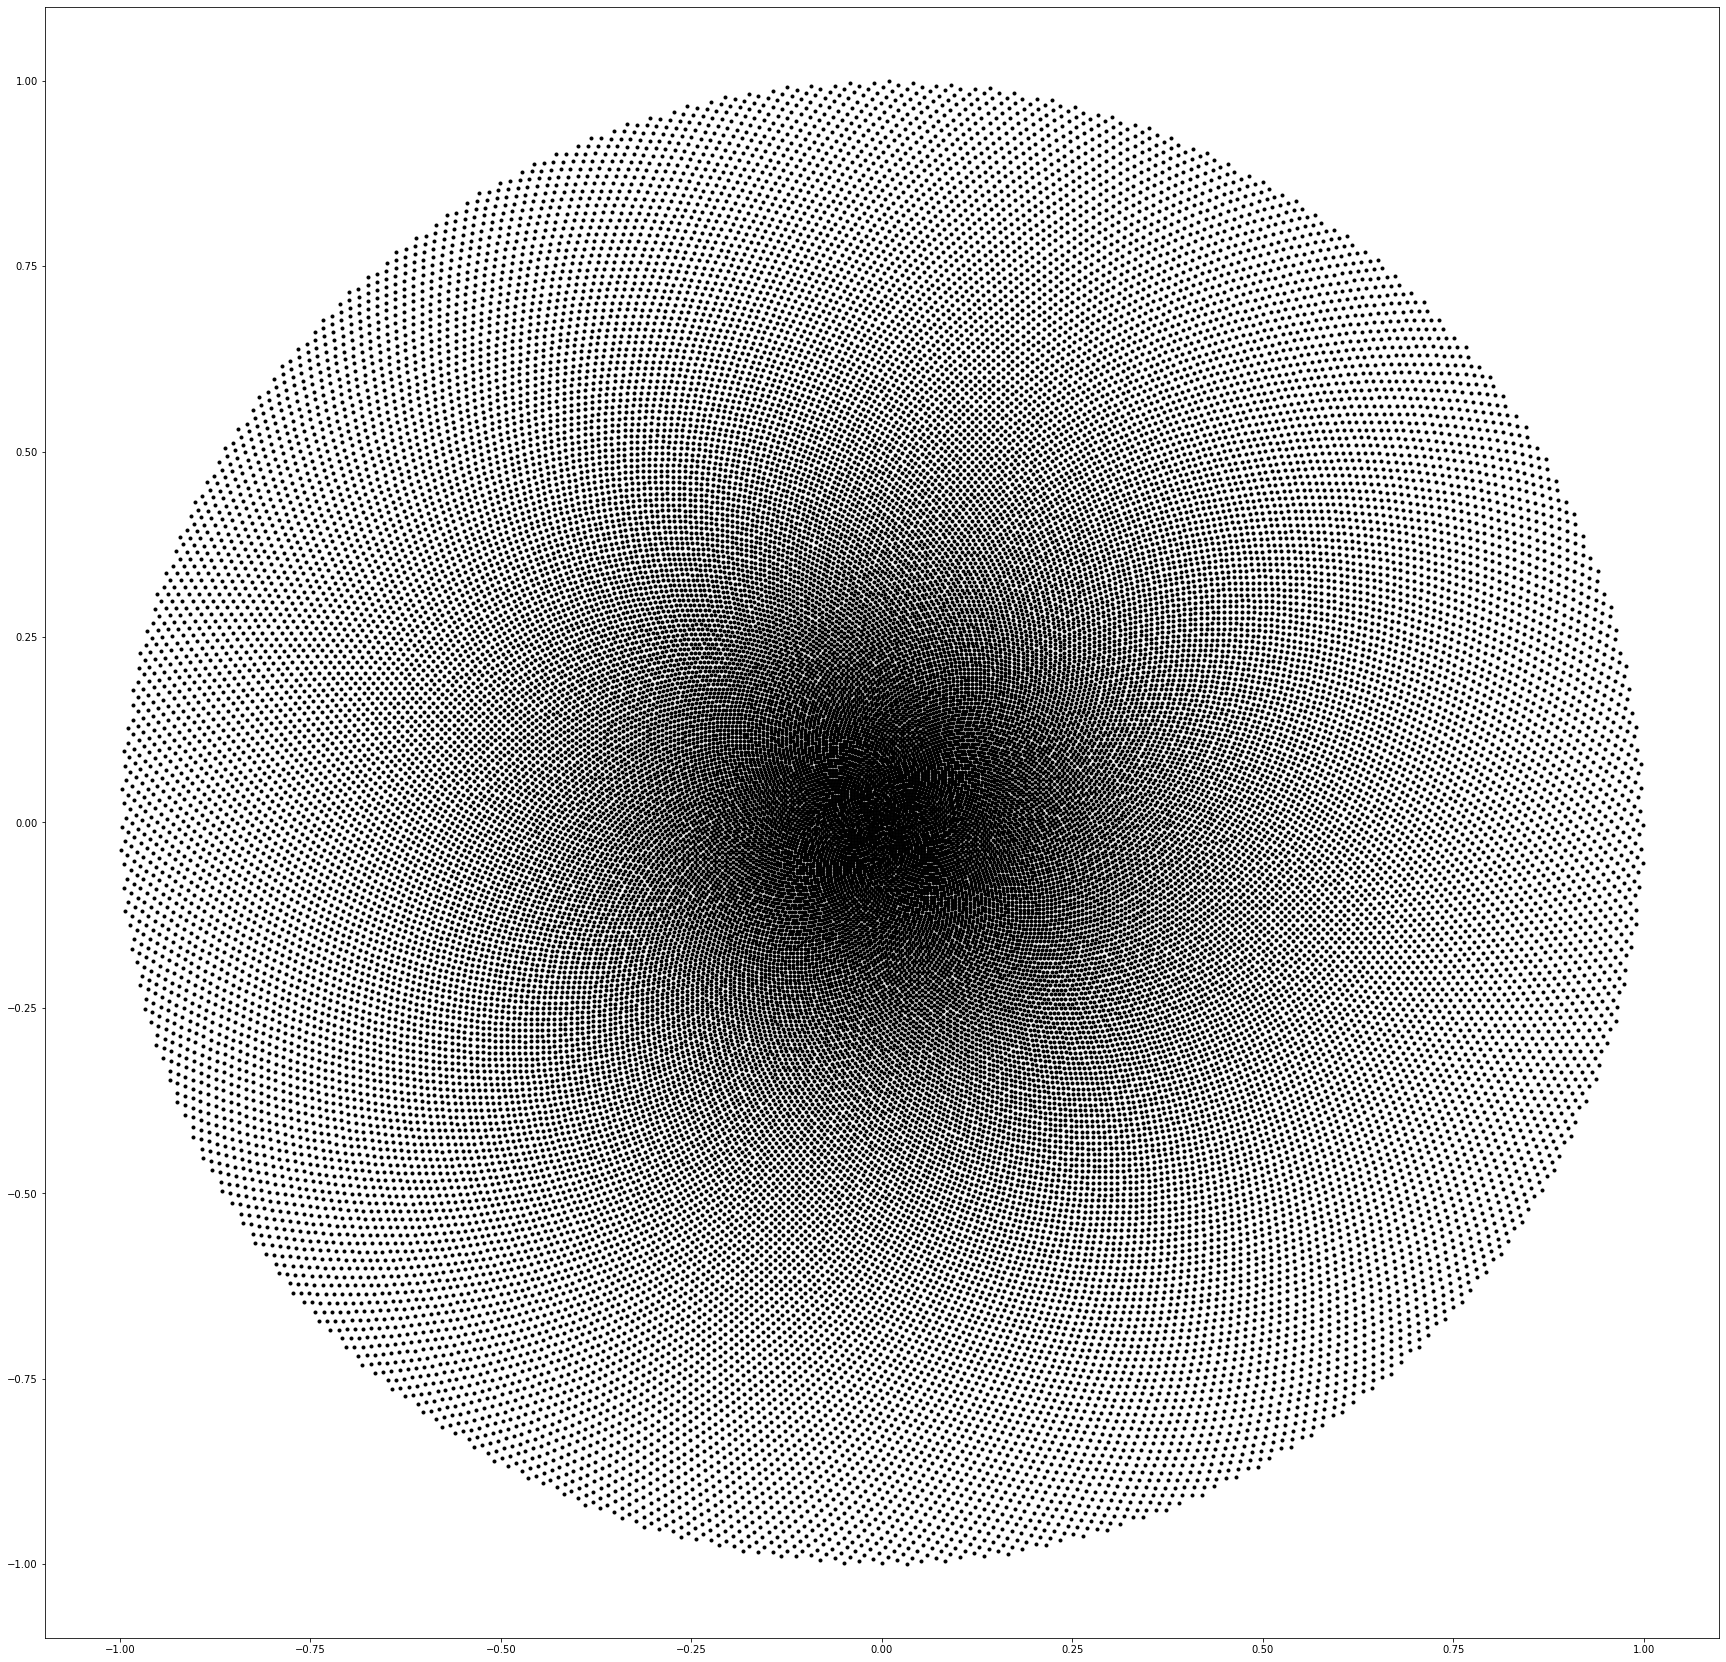

In [5]:
visualize_locs(fibonacci_retina(50000, 0.1, 1.6))

In [6]:
%%cython

cimport cython
from libc.math cimport round

cpdef find_kernel_center(float x, float y, int k_width):
    cdef float x_diff
    cdef float y_diff
    cdef char x_diff_sign
    cdef char y_diff_sign
    
    cx = round(x)
    cy = round(y)
    
    if not k_width & 1:
        x_diff = x-cx
        y_diff = y-cy
        x_diff_sign = (x_diff>0) - (x_diff<0)
        y_diff_sign = (y_diff>0) - (y_diff<0)
        cx += x_diff_sign*0.5
        cy += y_diff_sign*0.5
    
    return cx, cy

In [7]:
def visialuize_kernel(kernel):
    plt.figure(figsize=(8,8))
    plt.imshow(kernel, cmap='gray')
    plt.gca().set_axis_off()
    plt.show()

def gaussian2d(size=3, sigma = 3, x_offset=0, y_offset=0, amplitude=1):
    x = np.arange(size, dtype='float64')
    y = x[:,np.newaxis][::-1]
    x0 = y0 = (size-1) / 2.0
    x0 += x_offset
    y0 += y_offset
    
    return amplitude*np.exp(-(((x-x0)**2 /(2*sigma**2)) + ((y-y0)**2 /(2*sigma**2))))

def get_neighbors(triangulation):
    neighbours = [set() for _ in range(len(triangulation.points))]
    for t in triangulation.simplices:
        neighbours[t[0]].add(t[1])
        neighbours[t[0]].add(t[2])
        neighbours[t[1]].add(t[0])
        neighbours[t[1]].add(t[2])
        neighbours[t[2]].add(t[0])
        neighbours[t[2]].add(t[1])
    return neighbours

def calculate_neighborhood_size(tessellation, num_neighbors = 6):
    size = np.zeros(len(tessellation), dtype='float64')
    tree = KDTree(tessellation)
    for i in range(len(tessellation)):
        distance, index = tree.query(tessellation[i], k=num_neighbors+1)
        size[i] = np.mean(distance[1:])
    return size

def retina_field_generator_new(tessellation, scaling_factor=1, width_sigma_ratio=6, min_d=1):
    rf_loc = np.zeros((len(tessellation), 7))
    rf_coeff = np.ndarray(len(tessellation),dtype='object')
    
    triangulation = Delaunay(tessellation)
    neighbors = get_neighbors(triangulation)
    num_neighbors = np.array([len(neighbors[i]) for i in range(len(neighbors))])
    num_neighbors += 1
    
    size = np.zeros(len(tessellation), dtype='float64')
    tree = KDTree(tessellation)
    for i in range(len(tessellation)):
        distance, index = tree.query(tessellation[i], k=num_neighbors[i])
        size[i] = np.mean(distance[1:])
    
    #compute median size for most central 20 nodes
    fov_size = np.median(size[:20])
    
    #set fov_size to min_d (impose min_d parameter)
    rf_loc[:,:2] = tessellation*min_d/fov_size
    
    #Adjust size to reflect new scale
    size = size*min_d/fov_size
    
    #Insert angle to [3]
    rf_loc[:,3] = np.arctan2(rf_loc[:,1],rf_loc[:,0])
    
    #Insert size to [4]
    rf_loc[:,4] = size
    
    print("Generating coefficients")
    
    ##determine sigmas
    rf_loc[:,5] = size * scaling_factor
    
    #Use the same method as Sumitha for having even/odd kernels [compatibility]
    for i in range(len(tessellation)):
        loc = rf_loc[i]
        #determine and insert kernel widths
        k_width =  np.round(width_sigma_ratio*rf_loc[i,5])#int(max(min_kernel, np.ceil(width_sigma_ratio*rf_loc[i,4])))
        rf_loc[i,6] = k_width
        
        cx, cy = find_kernel_center(loc[0], loc[1], k_width)
        
        #Obtain subpixel accurate offsets from kernel centre
        rx = rf_loc[i][0] - cx
        ry = rf_loc[i][1] - cy
        
        x_offset = rx - int(rx)
        y_offset = ry - int(ry)
        
        #set [2] = eccentricity
        rf_loc[i,2] = np.linalg.norm(rf_loc[i,:2])
        
        #Set x, y, d
        rf_loc[i,0] = cx
        rf_loc[i,1] = cy
        
        #place proper gaussian in rf_coeff[i]
        rf_coeff[i] = gaussian2d(k_width,loc[5], x_offset, y_offset)
        rf_coeff[i] /= np.sum(rf_coeff[i])
    
    return rf_loc, rf_coeff

In [8]:
tess = fibonacci_retina(50000, 0.1, 1.6)
rf_loc, rf_coeff = retina_field_generator_new(tess)

Generating coefficients


In [9]:
with open('new_loc.pkl', 'wb') as f:
    pickle.dump(rf_loc, f)

with open('new_coeff.pkl', 'wb') as f:
    pickle.dump(rf_coeff, f)